# K-Means Clustering From Scratch
This notebook is an implementation of the K-Means algorithm from scratch, based on the book "Pattern Recognition and Machine Learning" by Christopher M. Bishop. We are using the Old Faithful geyser dataset, which is a dataset of eruptions of the Yellowstone Geyser. To see more information about the dataset [here](https://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat) or [here](https://gist.githubusercontent.com/curran/4b59d1046d9e66f2787780ad51a1cd87/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv).

We will breifly explain the K-Means algorithm, and then we will implement it from scratch. But for detailed information about the algorithm, please refer chapter 9, section 9.1 of the book.

In [393]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

## Data Preparation
We will download the data set and then create a panda dataframe. Lets see how the data looks like. 

In [394]:
# lets download the old faithful dataset from CMU website
# the data is avalable as .dat file
# and load it into a pandas dataframe
url = 'https://gist.githubusercontent.com/curran/4b59d1046d9e66f2787780ad51a1cd87/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv'
# the dataset is tab separated
df = pd.read_csv(url, sep='\t')
df.head()


,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


In [395]:
df.describe()

,eruptions,waiting
count,272.000000,272.000000
mean,3.487783,70.897059
std,1.141371,13.594974
min,1.600000,43.000000
25%,2.162750,58.000000
50%,4.000000,76.000000
75%,4.454250,82.000000
max,5.100000,96.000000


So the data set has two coloumns, the first one is the time of the eruption, and the second one is the duration of the eruption. There are total 272 data points. Though we do not need to know what these things means exactly to implement our algorithm in it but it is good to know the data set.

We can also observe the mean and variance of the features in the data set.

### About the Data Set
Old Faithful Geyser Data

Description: (From R manual):

Waiting time between eruptions and the duration of the eruption for the Old Faithful geyser in Yellowstone National Park, Wyoming, USA.

A data frame with 272 observations on 2 variables.

**eruptions** :  numeric  Eruption time in mins

**waiting** :    numeric  Waiting time to next eruption

References:

     Hardle, W. (1991) Smoothing Techniques with Implementation in S.
     New York: Springer.

     Azzalini, A. and Bowman, A. W. (1990). A look at some data on the
     Old Faithful geyser. Applied Statistics 39, 357-365.




### Visualising the Data
We will plot the data set to see how the data looks like. It will help us figure out if any human readable patterns can be found in the data.

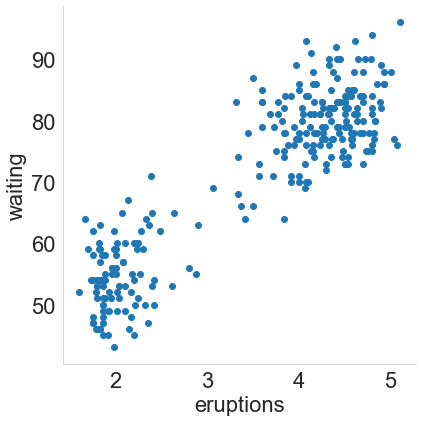

In [396]:
# plotting the data as a scatter plot
sns.set_style('whitegrid')
sns.lmplot(x = 'eruptions', y = 'waiting', data=df, fit_reg=False, height=6, scatter_kws={'alpha': 1})
plt.grid(False)
plt.show()


### Standarizing the Data
The data set is not standardized. To make our plots look similar to the plots in the book, we will standardize the data. Also standardizing the data has other benefits on quality of clustering as well. Please refer [this paper](https://www.researchgate.net/publication/288044597_Standardization_and_Its_Effects_on_K-Means_Clustering_Algorithm) for more information.

There are several ways to standardize the data. We will implement the standardization using the **z-score** method. This will convert the data ino zero mean and unit variance.

In [397]:
## z-score standardization
def z_score(df):
    # calculate mean of each column
    mean = sum(df.values) / len(df.values)
    # calculate standard deviation of each column
    std = (df.values - mean) ** 2
    std = sum(std) / len(df.values)
    # normalize the data
    df_norm = (df - df.mean()) / df.std()
    return df_norm

In [398]:
sdf = z_score(df)
sdf.describe()

,eruptions,waiting
count,2.720000e+02,2.720000e+02
mean,4.738856e-16,4.404157e-16
std,1.000000e+00,1.000000e+00
min,-1.653961e+00,-2.052013e+00
25%,-1.160913e+00,-9.486638e-01
50%,4.487733e-01,3.753550e-01
75%,8.467595e-01,8.166946e-01
max,1.412526e+00,1.846487e+00


We can see that the mean of each column is now zero and the variance is 1 with some precision error which can be ignored.

Now lets plot the data once again and see how they look like. There should not be much differenc in the plots because they were already on the different scales. And changing the mean only shifts the origin, but no loss in replotting the data.

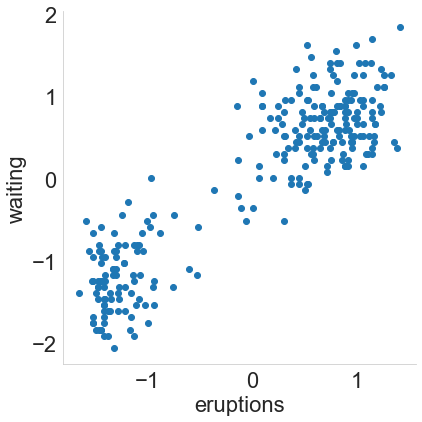

In [399]:
# plotting the data as a scatter plot
sns.set_style('whitegrid')
sns.lmplot(x = 'eruptions', y = 'waiting', data=sdf, fit_reg=False, height=6, scatter_kws={'alpha':1})
plt.grid(False)

## K-Means Clustering
K-Means clustering is a unsupervised learning algorithm. It is a clustering algorithm that is used to group similar data points together. The algorithm is based on the idea that the data points are similar if they are close to each other. The algorithm is also known as the **k-means** algorithm. 

The main purpose of the K-Mean algorithm is to minimise the sum of the squared distances between the data points and the centroids. The centroids are the points that are used to group the data points. The centroids are the means of the data points. This is basically done using two steps first we find the centroids and then we find the data points that are closest to the centroids. Then we repeat the process until the centroids do not change. We call these steps E step and M step respectively.

There are more general K-means algorithms available in which other metrics are used instead of squared distance.

Please refer section 9.1 of Book "Pattern Recognition and Machine Learning" by Christopher M. Bishop for more information about the K-Means algorithm.

We will write the K-Means algorithm from scratch, but we will use basic numpy and pandas functions to implement it, which will exploit the power of vectosised operation and makes things faster.

In [400]:
# one iteration of a e step of k means algorithm
def e_step(df, mu):
    # calculate the distance between each data point and each mean
    dist = np.zeros((len(df), len(mu)))
    for i in range(len(mu)):
        dist[:, i] = np.linalg.norm(df - mu[i], axis=1)
    # assign each data point to the mean with the smallest distance
    idx = np.argmin(dist, axis=1)
    return idx


In [401]:
# one iteration of a m step of k means algorithm
def m_step(df, idx):
    # calculate the mean of each cluster
    mu = np.zeros((len(np.unique(idx)), len(df.columns)))
    for i in range(len(np.unique(idx))):
        mu[i] = df[idx == i].mean(axis=0)
    return mu

In [402]:
# k means algorithm
def k_means(df, k, max_iter=10000):
    # initialize the means
    mu = np.zeros((k, len(df.columns)))
    for i in range(k):
        mu[i] = df.iloc[np.random.randint(0, len(df))]
    # initialize the clusters
    idx = np.zeros(len(df))
    # initialize the old clusters
    old_idx = np.zeros(len(df))
    # initialize the iteration counter
    iter = 0
    # lets save the idx and mu and cost for each iteration
    idx_mu = []
    # get initial cost
    cost = np.sum(np.linalg.norm(df - mu[idx.astype(int)], axis=1))
    idx_mu.append([idx.copy(), mu.copy(), cost ])
    # run the k means algorithm until convergence
    while iter < max_iter:
        # run the e step
        old_idx = idx.copy()
        idx = e_step(df, mu)
        cost = np.sum(np.linalg.norm(df - mu[idx], axis=1))
        idx_mu.append([idx.copy(), mu.copy(), cost])
        # run the m step
        mu = m_step(df, idx)
        # save the idx and mu and cost for each iteration
        cost = np.sum(np.linalg.norm(df - mu[idx], axis=1))
        idx_mu.append([idx.copy(), mu.copy(), cost])
        # check for convergence
        iter += 1
        if np.array_equal(idx, old_idx):
            break
    # caclutate the cost
    cost = 0
    for i in range(len(idx)):
        cost += np.linalg.norm(df.iloc[i] - mu[idx[i]])

    # store extra information about the algorithm in info dictionary
    # this will be useful for getting insights from the algorithm
    info = {'k': k ,'iter': iter, 'final_cost' : cost, 'idx_mu': idx_mu}
    return idx, mu, info

In [403]:
# apply k means algorithm to the dataset
idx, mu, info = k_means(sdf, 2)

In [404]:
# get some insights from the algorithm
print('k = ', info['k'])
print('iter = ', info['iter'])
print('final cost = ', info['final_cost'])


k =  2
iter =  4
final cost =  127.73206224852159


In [405]:
# create a new df with the cluster information joined to the original df
df_clustered = pd.DataFrame({'cluster': idx})
df_clustered = df_clustered.join(sdf)
df_clustered.head()

,cluster,eruptions,waiting
0,1,0.098318,0.596025
1,0,-1.478733,-1.242890
2,1,-0.135612,0.228242
3,0,-1.055558,-0.654437
4,1,0.915755,1.037364


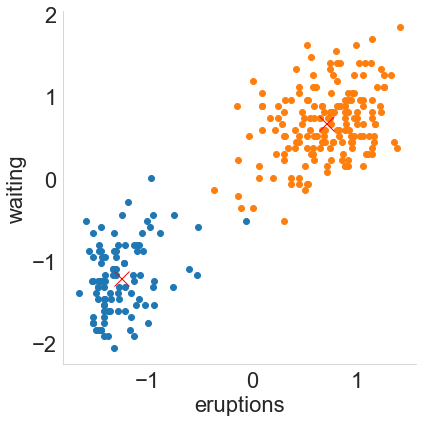

In [406]:
# plot the data with the each cluster as a different color 
def plot_clusters(df, idx, mu, markClusters = True):
    # create a new df with the cluster information joined to the original df
    df_clustered = pd.DataFrame({'cluster': idx})
    df_clustered = df_clustered.join(df)
    # plot the data with the each cluster as a different color 
    sns.lmplot(x = 'eruptions', y = 'waiting', data=df_clustered, fit_reg=False, height=6, scatter_kws={'alpha': 1}, hue='cluster', legend=False)
    plt.grid(False)
    # plot the means as a black x
    plt.plot(mu[:, 0], mu[:, 1], 'rx', markersize=15)
    return plt
plot_clusters(sdf, idx, mu).show()

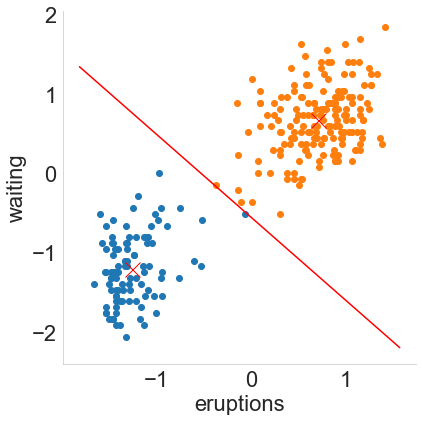

In [407]:
# we can even draw decision boundary lines easily for a 2 cluster case
def plot_boundary(df, idx, mu1, mu2, markClusters = True):
    # create a new df with the cluster information joined to the original df
    df_clustered = pd.DataFrame({'cluster': idx})
    df_clustered = df_clustered.join(df)
    # plot the data with the each cluster as a different color 
    sns.lmplot(x = 'eruptions', y = 'waiting', data=df_clustered, fit_reg=False, height=6, scatter_kws={'alpha': 1}, hue='cluster', legend=False)
    plt.grid(False)
    # plot the means as a black x
    plt.plot(mu1[0], mu1[1], 'rx', markersize=15)
    plt.plot(mu2[0], mu2[1], 'rx', markersize=15)
    
    # plot the decision boundary lines
    
    # find mid points of the means of the two clusters
    x_mid = (mu1[0] + mu2[0]) / 2
    y_mid = (mu1[1] + mu2[1]) / 2
    # find the slope of the line joining the two means
    slope = (mu1[1] - mu2[1]) / (mu1[0] - mu2[0])
    # find the slope of the perpendicular line
    slope_perp = -1 / slope
    # dont show legend for the points

    # find y intercept of the perpendicular line
    y_int = y_mid - slope_perp * x_mid

    # plot the perpendicular line in the plot area
    x_min = plt.xlim()[0]
    x_max = plt.xlim()[1]

    x = np.linspace(x_min, x_max, 100)
    y = [slope_perp * x_i + y_int for x_i in x]
    plt.plot(x, y, 'r-')
    return plt

plot_boundary(sdf, idx, mu[0], mu[1], markClusters = True).show()

### Visualising the custering steps
We will plot the data points and the centroids in each iteration of the K-Means algorithm. We will see how the centroids move and how the data points move to the centroids.

In [408]:
info.keys()

dict_keys(['k', 'iter', 'final_cost', 'idx_mu'])

In [409]:
# lets plot the clusters with the decision boundary lines for all iterations
# this will help us visualise how the algorithm proceeds
# we will use info return by our algorithm to plot the decision boundary lines
# info contaons the idx and mu for each iteration

# at even index we have the idx and mu for the step when a new mean is calculated
# at odd index we have the idx and mu for the step when clusters are reassigned
# we will use that to generate a set of subplots

# we will write similar logic created functions plot clusters and plot boundary
idx_mu = info['idx_mu']
num_plots = len(idx_mu)

# we will use matplot lib to create a grid of subplots 
# we will try to imitate the figure as shown in the book
# our plot will have 3 columns and in the book but rows may chnage based on iterations
plt.rcParams.update({'font.size': 16})
def plot_clusters_and_boundary(df, idx_mu, num_plots, markClusters = True):
    fig, ax = plt.subplots(math.ceil(num_plots/3), 3, figsize=(20, 20))
    for i in range(num_plots-1):
        # get the idx and mu for the current iteration
        idx = idx_mu[i][0]
        mu = idx_mu[i][1]
        
        
        # plot the data with the each cluster as a different color 
        # use matplotlib to plot the data at the current subplot
        ax[i//3, i%3].scatter(df['eruptions'], df['waiting'], c=idx, cmap='bwr', alpha=1)
        # plot the means with their respective color and white border
        ax[i//3, i%3].scatter(mu[0,0], mu[0, 1], c='c', marker='X', s=300, edgecolor='white')
        ax[i//3, i%3].scatter(mu[1,0], mu[1, 1], c='orange', marker='X', s=300, edgecolor='white')

        ax[i//3, i%3].set_title('Iteration ' + str(i//2))
        # turn off the grid
        ax[i//3, i%3].grid(False)

        if i%2 != 0:
            # we need to create the decision boundary lines
            # find mid points of the means of the two clusters
            x_mid = (mu[0, 0] + mu[1, 0]) / 2
            y_mid = (mu[0, 1] + mu[1, 1]) / 2
            # find the slope of the line joining the two means
            slope = (mu[0, 1] - mu[1, 1]) / (mu[0, 0] - mu[1, 0])
            # find the slope of the perpendicular line
            slope_perp = -1 / slope
            # find the intercept of the perpendicular line
            y_int = y_mid - slope_perp * x_mid
            x = np.linspace(plt.xlim()[0] - 1, plt.xlim()[1] + 1, 100)
            y = [slope_perp * x_i + y_int for x_i in x]
            # plot the line in the plot area
            ax[i//3, i%3].plot(x, y, 'r-')

        # remove the impty axes

plot_clusters_and_boundary(sdf, idx_mu, num_plots, markClusters = True)

### Loss Function
Now lets see the loss function per iteration. The loss function is the sum of the squared distances between the data points and the centroids. The loss function is used to measure the quality of the clustering. The lower the loss function, the better the clustering.

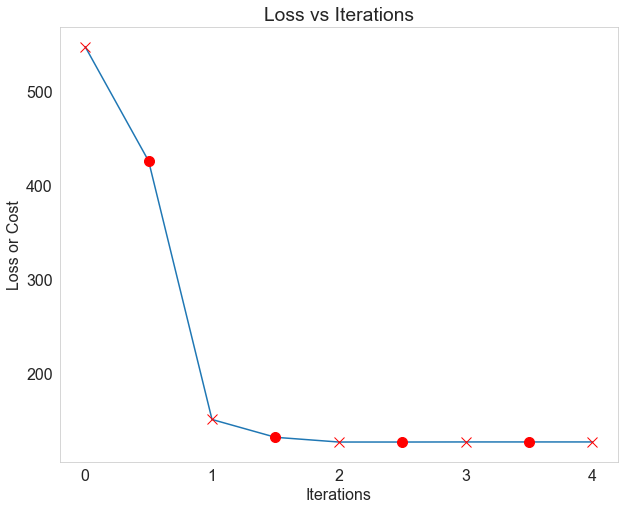

In [410]:
# loss function
# we have already stored the loss function in the info dictionary
loss = []
for i in range(len(idx_mu)):
    loss.append(idx_mu[i][2])

x = np.arange(len(loss))/2
x_even = x[::2]
e_odd = x[1::2]
loss_even = loss[::2]
loss_odd = loss[1::2]
figure = plt.figure(figsize=(10, 8))
plt.plot(x, loss)
plt.xlabel('Iterations')
plt.ylabel('Loss or Cost')
plt.title('Loss vs Iterations')
plt.grid(False)

# mark the points
plt.plot(x_even, loss_even, 'rx', markersize=10)
plt.plot(e_odd, loss_odd, 'ro', markersize=10)

# increase the font size
plt.rcParams.update({'font.size': 22})

plt.show()


## Conclusion
We can see that K-Means is succesfully able to separate the data points into two clusters, which is also the expected result.